# ST-590 Final Project
*Performed by: Muhammer Kurt, Nataliya Peshekhodko*

*08/01/2022*

## Introduction

The goals of this project are 
* Find a data set to explore and fit supervised learning models
* Conducting EDA through pandas-on-spark
* Fitting three different classes of models and choosing a best model

## Dataset

To achieve goals of this project Diabetic Data set from [Kaggle](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) was chosen. This data set will be used to predict based on diagnostic measurements whether a patient has diabetes. We will build and fit classification models.

Variables in data set:
- *Pregnancies* - number of times pregnant
- *Glucose* - plasma glucose concentration a 2 hours in an oral glucose tolerance test
- *BloodPressure* - diastolic blood pressure (mm Hg)
- *SkinThickness* - triceps skin fold thickness (mm)
- *Insulin* - 2-Hour serum insulin (mu U/ml)
- *BMI* - body mass index (weight in kg/(height in m)^2)
- *DiabetesPedigreeFunction* - diabetes pedigree function
- *Age* - age (years)
- *Outcome* - class variable (0 or 1), 0 if patient doesn't have diabetic, 1 if patient has diabetic.

## Data preparation

Import libraries and set up spark session.

In [1]:
# supress all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import os
import sys
import pyspark.pandas as ps
from pyspark.sql import SparkSession

from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import VectorAssembler
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.getOrCreate()

Read data from `diabetics.csv` file.

In [2]:
data = pd.read_csv("data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Before split up data into train and test data sets we need to replace zero values for Blood pressure and Body mass index. These variables can't be equal to zero in real life.

In [3]:
print ("Number of 0 values for Diastolic Blood Pressure is "+ str(data[data.BloodPressure==0].BloodPressure.count()) +  
       "\nNumber of 0 values for Body Mass Index is " + str (data[data.BMI==0].BMI.count()))

Number of 0 values for Diastolic Blood Pressure is 35
Number of 0 values for Body Mass Index is 11


We will replace zero values for these variables with means for these variables (mean calculation will be adjusted not to include zero values).

In [4]:
data.BloodPressure.replace(0,data[data.BloodPressure!=0].BloodPressure.mean(),inplace=True)
data.BMI.replace (0, data[data.BMI!=0].BMI.mean(),inplace=True)

Convert pandas data frame into spark data frame.

In [5]:
diabetes = spark.createDataFrame(data)
diabetes.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|         72.0|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|         66.0|           29|      0|26.6|     0.35100000000000003| 31|      0|
|          8|    183|         64.0|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|         66.0|           23|     94|28.1|     0.16699999999999998| 21|      0|
|          0|    137|         40.0|           35|    168|43.1|      2.2880000000000003| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



Split up data set into training (80% of data) and testing (20% of data) data sets.

In [6]:
train, test = diabetes.randomSplit([0.8,0.2], seed = 1)
print(train.count(), test.count())

607 161


In [7]:
train.show(5)

+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|    BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
|          0|    100|             88.0|           60|    110|46.8|      0.9620000000000001| 31|      0|
|          0|    101|             65.0|           28|      0|24.6|                   0.237| 22|      0|
|          0|    105|             64.0|           41|    142|41.5|     0.17300000000000001| 22|      0|
|          0|    109|             88.0|           30|      0|32.5|                   0.855| 38|      1|
|          0|    131|72.40518417462484|            0|      0|43.2|                    0.27| 26|      1|
+-----------+-------+-----------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



## Exploratory data analysis

In this section we will conduct explanatory data analysis on training data set.

Let's start with describing all numeric feature variables (*splitting up into two tables for easy reading*) and count the outcome variable for each outcome. 

In [8]:
train.select('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness' ).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|       Pregnancies|           Glucose|     BloodPressure|     SkinThickness|
+-------+------------------+------------------+------------------+------------------+
|  count|               607|               607|               607|               607|
|   mean|3.7891268533772653|119.36738056013179| 72.65923480269974|20.191103789126853|
| stddev| 3.322840308863052|31.996263038169634|12.153251936684262|15.679958827932095|
|    min|                 0|                 0|              24.0|                 0|
|    max|                15|               199|             122.0|                63|
+-------+------------------+------------------+------------------+------------------+



In [9]:
train.select('Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age' ).describe().show()

+-------+-----------------+-----------------+------------------------+------------------+
|summary|          Insulin|              BMI|DiabetesPedigreeFunction|               Age|
+-------+-----------------+-----------------+------------------------+------------------+
|  count|              607|              607|                     607|               607|
|   mean| 75.0313014827018|32.50078193858964|      0.4653492586490939| 33.27347611202636|
| stddev|110.6757998930512| 6.96829781648047|     0.32853833196886145|11.871187278518361|
|    min|                0|             18.2|                   0.085|                21|
|    max|              846|             67.1|                    2.42|                81|
+-------+-----------------+-----------------+------------------------+------------------+



In [10]:
train.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      0|  401|
|      1|  206|
+-------+-----+



From the tables above it could be seen that there are zero min values for variables `Pregnancies`, `Glucose`, `SkinThickness` and `Insulin` which is acceptable. In the train data set we have almost twice more observations for healthy patients comparing with diabetics patients.

Check if there are any null values in the train data set.

In [11]:
import pyspark.sql.functions as f
# checking for null values in each column
data_agg = train.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in train.columns])
data_agg.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



Now, let's look at min, mean and max values for each numeric feature variable in context of the outcome variable.

In [12]:
expl_vars = ['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin',
            'DiabetesPedigreeFunction', 'Age', 'BMI']

min_values = train.groupBy('Outcome').agg({var: 'min' for var in expl_vars})
min_values.show()

avg = train.groupBy('Outcome').agg({var: 'avg' for var in expl_vars[0:4]})
avg.show()
avg = train.groupBy('Outcome').agg({var: 'avg' for var in expl_vars[4:]})
avg.show()

max_values = train.groupBy('Outcome').agg({var: 'max' for var in expl_vars})
max_values.show()

+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+
|Outcome|min(Pregnancies)|min(Insulin)|min(DiabetesPedigreeFunction)|min(SkinThickness)|min(Age)|min(BloodPressure)|min(BMI)|min(Glucose)|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+
|      0|               0|           0|                        0.085|                 0|      21|              24.0|    18.2|           0|
|      1|               0|           0|          0.08800000000000001|                 0|      21|              30.0|    23.3|           0|
+-------+----------------+------------+-----------------------------+------------------+--------+------------------+--------+------------+

+-------+------------------+------------------+------------------+-----------------+
|Outcome|avg(BloodPressure)|      avg(Glucose)|avg(SkinThickness)| avg(Pregnanci

From the tables above it could be seen that 
- min values for the variables `BloodPressure` and `BMI` for healthy patients are different from mean values for diabetic patients
- average values for the variables `Glucose`, `Insulin` are significantly higher for diabetics patients comparing with healthy patients

Let's visualize distributions for each numeric variable in the context of the outcome variable.

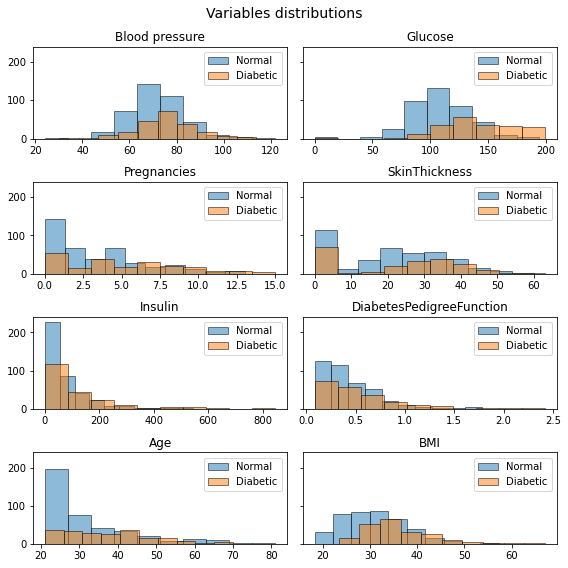

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
ps.options.plotting.backend = 'matplotlib'

eda_train = train.to_pandas_on_spark()

fig, axs = plt.subplots(4, 2, sharey=True, tight_layout=True, figsize = (8, 8))
fig.suptitle("Variables distributions", fontsize=14)
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "0", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label="Normal")
axs[0,0].hist(eda_train.loc[eda_train.Outcome == "1", ["BloodPressure"]].BloodPressure,  alpha = 0.5, ec="black", label = "Diabetic")
axs[0,0].set_title("Blood pressure")
axs[0,0].legend()


axs[0,1].hist(eda_train.loc[eda_train.Outcome == "0", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label="Normal")
axs[0,1].hist(eda_train.loc[eda_train.Outcome == "1", ["Glucose"]].Glucose,  alpha = 0.5, ec="black", label = "Diabetic")
axs[0,1].set_title("Glucose")
axs[0,1].legend()

axs[1,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label="Normal")
axs[1,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Pregnancies"]].Pregnancies,  alpha = 0.5, ec="black", label = "Diabetic")
axs[1,0].set_title("Pregnancies")
axs[1,0].legend()


axs[1,1].hist(eda_train.loc[eda_train.Outcome == "0", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label="Normal")
axs[1,1].hist(eda_train.loc[eda_train.Outcome == "1", ["SkinThickness"]].SkinThickness,  alpha = 0.5, ec="black", label = "Diabetic")
axs[1,1].set_title("SkinThickness")
axs[1,1].legend()


axs[2,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label="Normal")
axs[2,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Insulin"]].Insulin,  alpha = 0.5, ec="black", label = "Diabetic")
axs[2,0].set_title("Insulin")
axs[2,0].legend()

axs[2,1].hist(eda_train.loc[eda_train.Outcome == "0", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label="Normal")
axs[2,1].hist(eda_train.loc[eda_train.Outcome == "1", ["DiabetesPedigreeFunction"]].DiabetesPedigreeFunction,  alpha = 0.5, ec="black", label = "Diabetic")
axs[2,1].set_title("DiabetesPedigreeFunction")
axs[2,1].legend()


axs[3,0].hist(eda_train.loc[eda_train.Outcome == "0", ["Age"]].Age,  alpha = 0.5, ec="black", label="Normal")
axs[3,0].hist(eda_train.loc[eda_train.Outcome == "1", ["Age"]].Age,  alpha = 0.5, ec="black", label = "Diabetic")
axs[3,0].set_title("Age")
axs[3,0].legend()

axs[3,1].hist(eda_train.loc[eda_train.Outcome == "0", ["BMI"]].BMI,  alpha = 0.5, ec="black", label="Normal")
axs[3,1].hist(eda_train.loc[eda_train.Outcome == "1", ["BMI"]].BMI,  alpha = 0.5, ec="black", label = "Diabetic")
axs[3,1].set_title("BMI")
axs[3,1].legend()

From the histograms above it could be seen that distributions of `Blood pressure`, `Glucose`, `Insulin`, `Age` and `BMI` are different for each outcome.

Now, let's see if there are correlations between feature numeric variables.

In [14]:
eda_train[['BloodPressure', 'Pregnancies', 'Glucose', 'SkinThickness', 'Insulin','DiabetesPedigreeFunction', 'Age', 'BMI']].corr()

,BloodPressure,Pregnancies,Glucose,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,BMI
BloodPressure,1.000000,0.189019,0.230920,0.007712,-0.054817,-0.011798,0.335703,0.242875
Pregnancies,0.189019,1.000000,0.125612,-0.096489,-0.061967,-0.066191,0.540907,-0.009001
Glucose,0.230920,0.125612,1.000000,0.045829,0.295180,0.107185,0.261922,0.224549
SkinThickness,0.007712,-0.096489,0.045829,1.000000,0.449423,0.176543,-0.128871,0.375401
Insulin,-0.054817,-0.061967,0.295180,0.449423,1.000000,0.137497,-0.017874,0.157282
DiabetesPedigreeFunction,-0.011798,-0.066191,0.107185,0.176543,0.137497,1.000000,0.022669,0.154629
Age,0.335703,0.540907,0.261922,-0.128871,-0.017874,0.022669,1.000000,0.006848
BMI,0.242875,-0.009001,0.224549,0.375401,0.157282,0.154629,0.006848,1.000000


There are no significant correlation between numeric variables in the data set.

<AxesSubplot:title={'center':'Insulin vs # of pregnancies'}, xlabel='Insulin', ylabel='Pregnancies'>

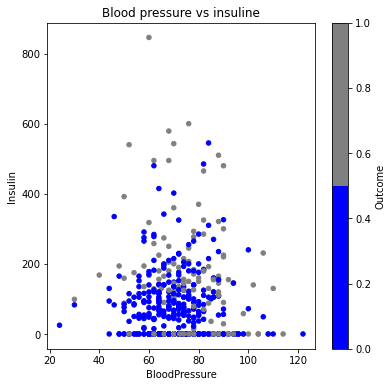

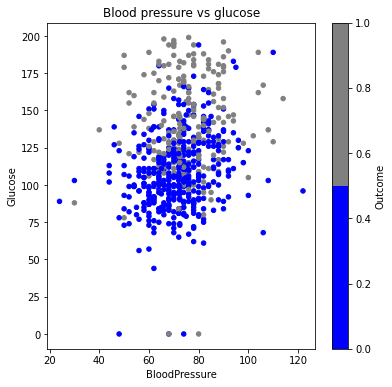

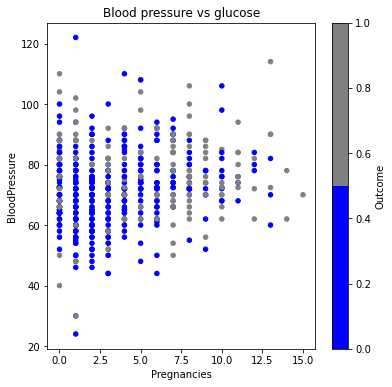

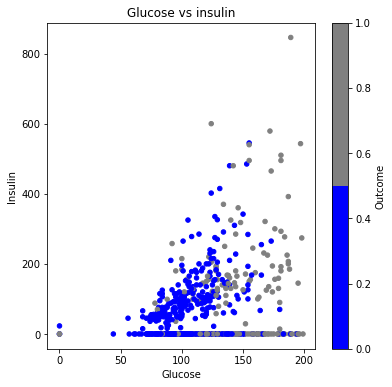

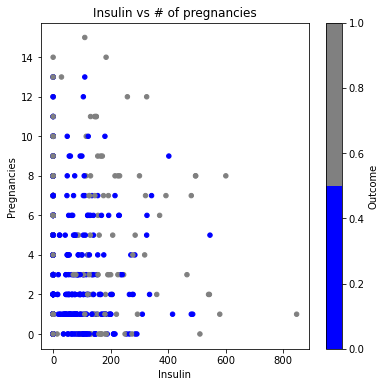

In [15]:
mycmap = colors.ListedColormap(['blue', 'grey'])
eda_train.plot.scatter(x='BloodPressure', y='Insulin', c = 'Outcome', colormap = mycmap, 
                       ylabel = "Insulin level", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs insuline",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='BloodPressure', y='Glucose', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "Glucose", 
                       xlabel = "Blood pressure",
                       title = "Blood pressure vs glucose",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='Pregnancies', y='BloodPressure', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "BloodPressure", 
                       xlabel = "# of Pregnancies",
                       title = "Blood pressure vs glucose",
                       sharex = False,
                       figsize = (6, 6))

eda_train.plot.scatter(x='Glucose', y='Insulin', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "Insulin", 
                       xlabel = "Glucose",
                       title = "Glucose vs insulin",
                       sharex = False,
                       figsize = (6, 6))
eda_train.plot.scatter(x='Insulin', y='Pregnancies', c = 'Outcome', colormap = mycmap, #colormap = "tab10",
                       ylabel = "# of pregnancies", 
                       xlabel = "Insulin",
                       title = "Insulin vs # of pregnancies",
                       sharex = False,
                       figsize = (6, 6))

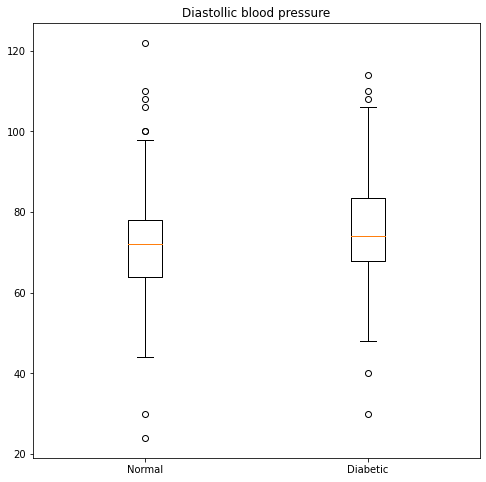

In [16]:
plt.rcParams['figure.figsize'] = [8, 8]
a = eda_train.loc[eda_train['Outcome'] == 0, 'BloodPressure']
b = eda_train.loc[eda_train['Outcome'] == 1, 'BloodPressure']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Diastollic blood pressure')
plt.show()

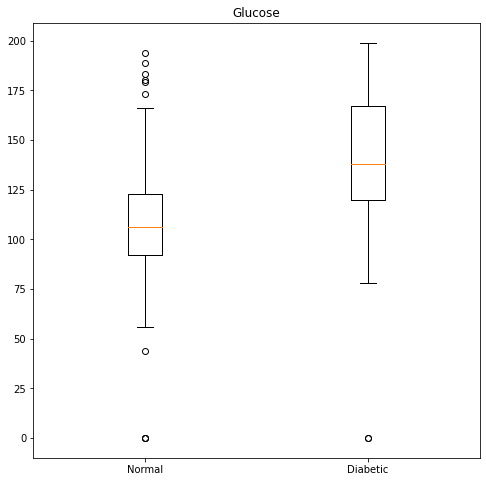

In [17]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Glucose']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Glucose']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Glucose')
plt.show()

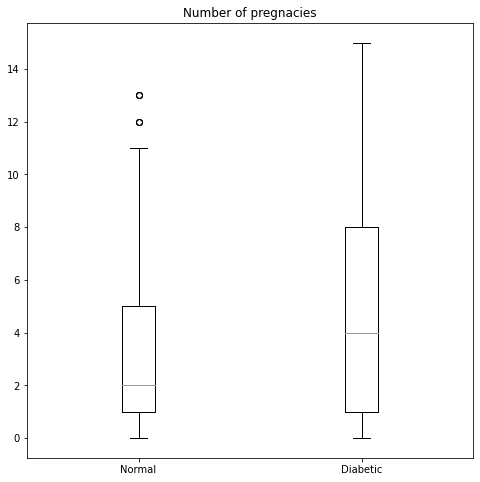

In [18]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Pregnancies']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Pregnancies']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Number of pregnacies')
plt.show()

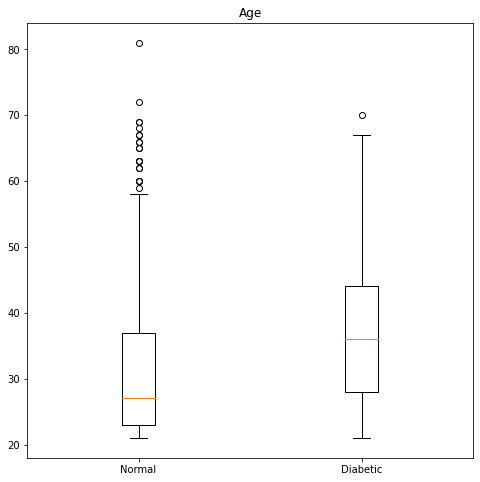

In [19]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Age']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Age']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Age')
plt.show()

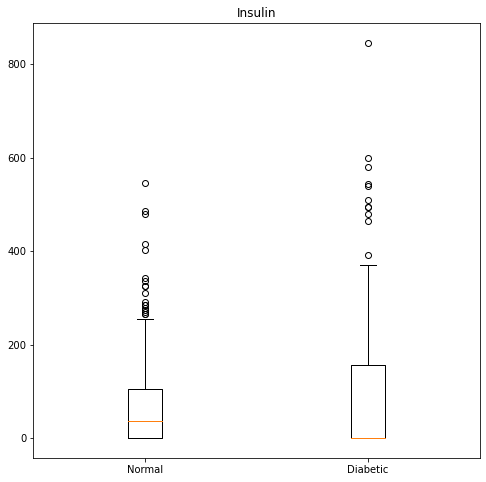

In [20]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'Insulin']
b = eda_train.loc[eda_train['Outcome'] == 1, 'Insulin']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('Insulin')
plt.show()

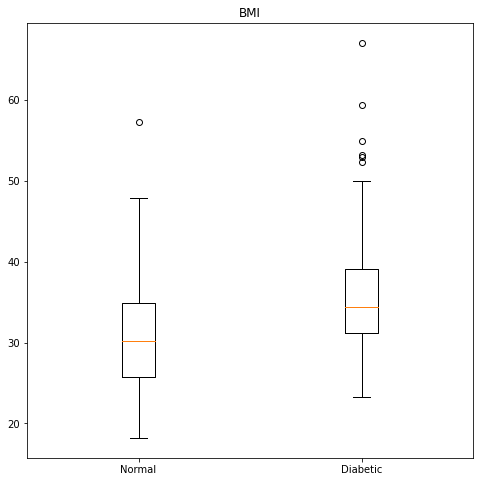

In [21]:
a = eda_train.loc[eda_train['Outcome'] == 0, 'BMI']
b = eda_train.loc[eda_train['Outcome'] == 1, 'BMI']

data = [a,b]

for i, x in enumerate(data):
    plt.boxplot(x, positions=[i])

plt.xticks([0,1], ['Normal','Diabetic'])
plt.title ('BMI')
plt.show()

## Modeling 

Three different classes of models will be fitted.

### Model 1

In [22]:
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression()

sqlTrans = SQLTransformer(
    statement = "SELECT log(Age) as Age, Glucose, \
    Insulin, Pregnancies, BloodPressure, BMI, \
    outcome as label FROM __THIS__")

assembler = VectorAssembler(inputCols = ["Age", "Glucose", "Insulin", "Pregnancies", "BloodPressure", "BMI"], outputCol = "features_for", handleInvalid = 'keep')

px = PolynomialExpansion(degree=2, inputCol="features_for", outputCol="features")

pipeline = Pipeline(stages = [sqlTrans, assembler, px, lr])

In [23]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [24]:
cvModel = crossval.fit(train)

In [25]:
cvModel.avgMetrics

[0.8216783982884803, 0.8257529967031626]

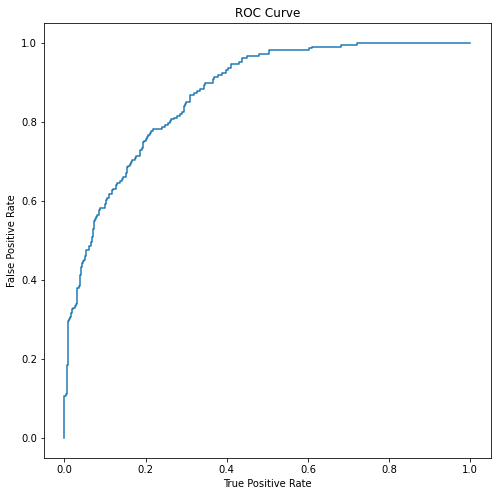

In [26]:
model_t= cvModel.bestModel.stages[3] 
trainingSummary = model_t.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

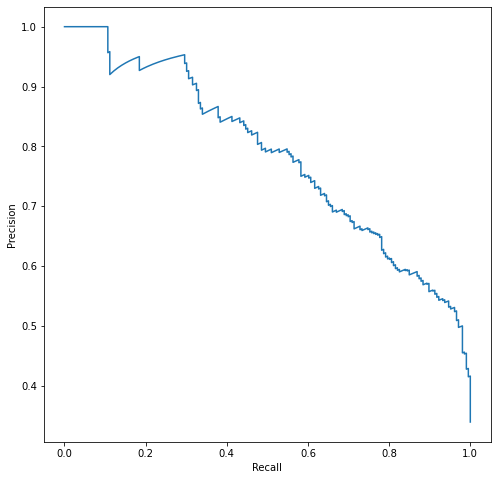

In [27]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [28]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.8216783982884803,
  {Param(parent='LogisticRegression_9feba71be381', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_9feba71be381', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_9feba71be381', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.8257529967031626,
  {Param(parent='LogisticRegression_9feba71be381', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_9feba71be381', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_9feba71be381', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

In [29]:
cvModel.transform(test).show(5)

+------------------+-------+-------+-----------+-------------+----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|               Age|Glucose|Insulin|Pregnancies|BloodPressure| BMI|label|        features_for|            features|       rawPrediction|         probability|prediction|
+------------------+-------+-------+-----------+-------------+----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|3.4339872044851463|    118|    230|          0|         84.0|45.8|    1|[3.43398720448514...|[3.43398720448514...|[0.39145720990271...|[0.59663344364178...|       0.0|
|3.4339872044851463|     85|      0|          1|         66.0|26.6|    0|[3.43398720448514...|[3.43398720448514...|[2.92565722063373...|[0.94910028874585...|       0.0|
| 3.044522437723423|     89|     94|          1|         66.0|28.1|    0|[3.04452243772342...|[3.04452243772342...|[4.70817534080030...|[0.99105943163109..

In [30]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print(metric)

0.7818507657217335


In [31]:
BinaryClassificationEvaluator().getMetricName()

'areaUnderROC'

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)#,labels=class_names)
cnf_matrix

array([[79, 20],
       [28, 34]])

In [33]:
# This function was taken from the repo https://runawayhorse001.github.io/LearningApacheSpark/classification.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[79 20]
 [28 34]]


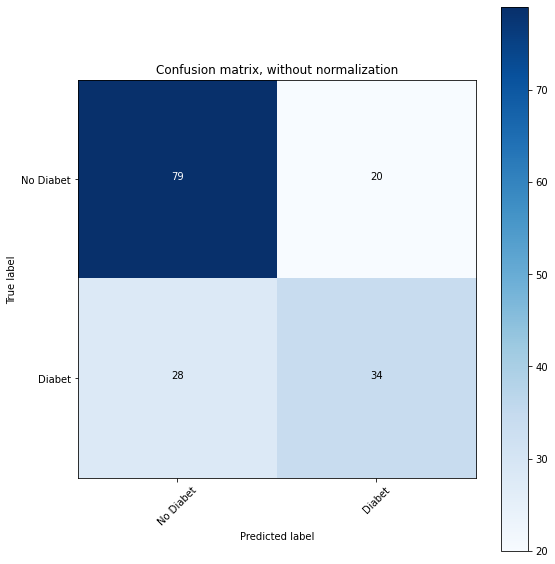

In [34]:
# Plot non-normalized confusion matrix
class_names =["No Diabet", "Diabet"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.7979798 0.2020202]
 [0.4516129 0.5483871]]


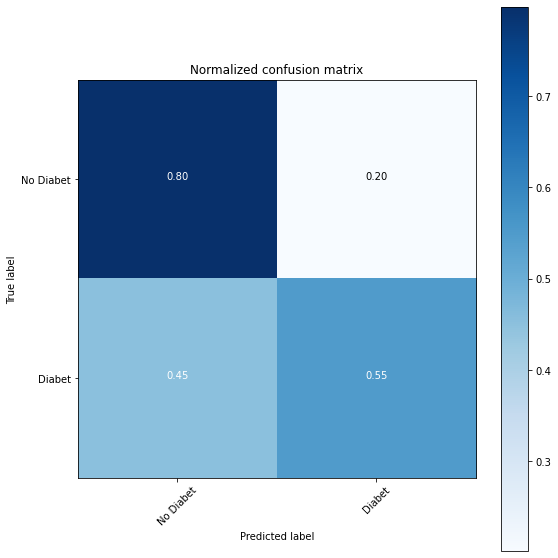

In [35]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 2

In [36]:
sqlTrans = SQLTransformer(
    statement = "SELECT Age, BloodPressure, \
    Pregnancies, Glucose, SkinThickness, \
    Insulin, DiabetesPedigreeFunction, BMI, \
    outcome as label FROM __THIS__"
)

assembler = VectorAssembler(inputCols = ["Age", "BloodPressure", "Pregnancies", "Glucose", "SkinThickness", "Insulin", "DiabetesPedigreeFunction", "BMI"], outputCol = "features", handleInvalid = 'keep')
pipeline = Pipeline(stages = [sqlTrans, assembler, lr])

In [37]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [38]:
cvModel = crossval.fit(train)

In [39]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.708562485782167,
  {Param(parent='LogisticRegression_9feba71be381', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_9feba71be381', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_9feba71be381', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.8409802115199392,
  {Param(parent='LogisticRegression_9feba71be381', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_9feba71be381', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_9feba71be381', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

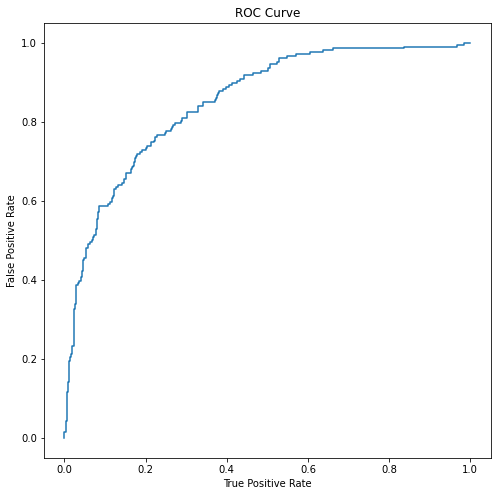

In [40]:
model2= cvModel.bestModel.stages[2]
trainingSummary = model2.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

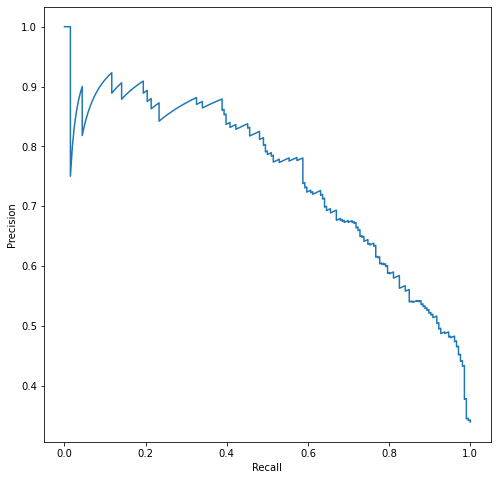

In [41]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [42]:
cvModel.transform(test).show(5)

+---+-------------+-----------+-------+-------------+-------+------------------------+----+-----+--------------------+--------------------+--------------------+----------+
|Age|BloodPressure|Pregnancies|Glucose|SkinThickness|Insulin|DiabetesPedigreeFunction| BMI|label|            features|       rawPrediction|         probability|prediction|
+---+-------------+-----------+-------+-------------+-------+------------------------+----+-----+--------------------+--------------------+--------------------+----------+
| 31|         84.0|          0|    118|           47|    230|                   0.551|45.8|    1|[31.0,84.0,0.0,11...|[0.30651680555722...|[0.57603482598769...|       0.0|
| 31|         66.0|          1|     85|           29|      0|     0.35100000000000003|26.6|    0|[31.0,66.0,1.0,85...|[3.39836758910215...|[0.96765347946368...|       0.0|
| 21|         66.0|          1|     89|           23|     94|     0.16699999999999998|28.1|    0|[21.0,66.0,1.0,89...|[3.30484526126503...|[

In [43]:
predictions = cvModel.transform(test)

metric = BinaryClassificationEvaluator().evaluate(predictions)
print(metric)

0.7859237536656892


In [44]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)#,labels=class_names)
cnf_matrix

array([[79, 20],
       [27, 35]])

Confusion matrix, without normalization
[[79 20]
 [27 35]]


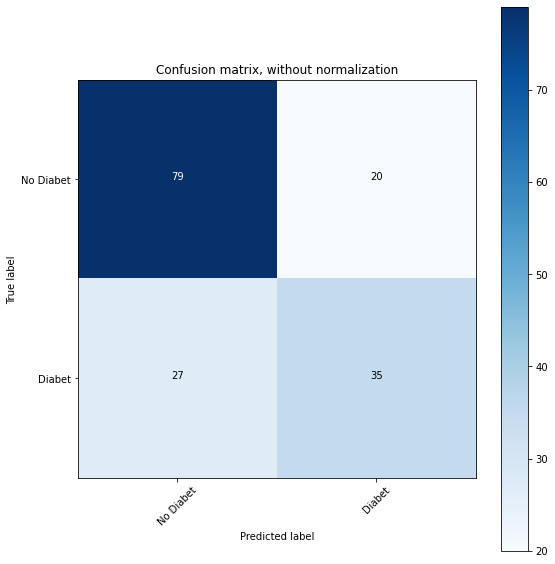

In [45]:
# Plot non-normalized confusion matrix
class_names =["No Diabet", "Diabet"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.7979798  0.2020202 ]
 [0.43548387 0.56451613]]


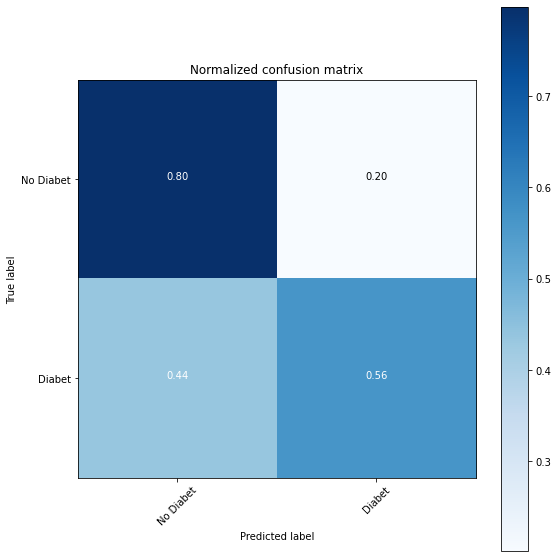

In [46]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 3

In [47]:
sqlTrans = SQLTransformer(
    statement = "SELECT Pregnancies, Glucose, Insulin, Glucose*Insulin as Inter, BMI, outcome as label FROM __THIS__")

assembler = VectorAssembler(inputCols = ["Pregnancies", "Glucose", "Insulin", "Inter", "BMI"], outputCol = "features", handleInvalid = 'keep')

#px = PolynomialExpansion(degree=2, inputCol="features_for", outputCol="features")

#pipeline = Pipeline(stages = [sqlTrans, assembler, px, lr])

pipeline = Pipeline(stages = [sqlTrans, assembler, lr])

In [48]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()
crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds=5)

In [49]:
cvModel = crossval.fit(train)

In [50]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.6527018403762485,
  {Param(parent='LogisticRegression_9feba71be381', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_9feba71be381', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_9feba71be381', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.8385244121816595,
  {Param(parent='LogisticRegression_9feba71be381', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LogisticRegression_9feba71be381', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LogisticRegression_9feba71be381', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

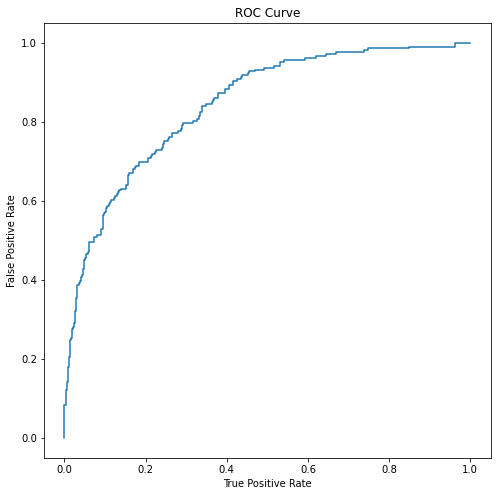

In [51]:
model3= cvModel.bestModel.stages[2]
trainingSummary = model3.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

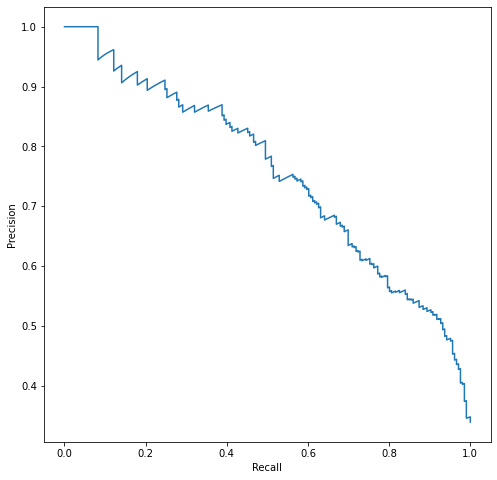

In [52]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [53]:
cvModel.transform(test).show(5)

+-----------+-------+-------+-----+----+-----+--------------------+--------------------+--------------------+----------+
|Pregnancies|Glucose|Insulin|Inter| BMI|label|            features|       rawPrediction|         probability|prediction|
+-----------+-------+-------+-----+----+-----+--------------------+--------------------+--------------------+----------+
|          0|    118|    230|27140|45.8|    1|[0.0,118.0,230.0,...|[0.44852875255824...|[0.61028937480154...|       0.0|
|          1|     85|      0|    0|26.6|    0|[1.0,85.0,0.0,0.0...|[3.03864203947611...|[0.95428963024146...|       0.0|
|          1|     89|     94| 8366|28.1|    0|[1.0,89.0,94.0,83...|[3.11138077158310...|[0.95735975732071...|       0.0|
|          1|     95|     38| 3610|19.6|    0|[1.0,95.0,38.0,36...|[3.62384568264081...|[0.97401344155966...|       0.0|
|          1|    101|     36| 3636|24.2|    0|[1.0,101.0,36.0,3...|[2.89318022468460...|[0.94750827959482...|       0.0|
+-----------+-------+-------+---

In [54]:
predictions = cvModel.transform(test)
metric = BinaryClassificationEvaluator().evaluate(predictions)
print(metric)

0.7655588139459107


Confusion matrix, without normalization
[[79 20]
 [27 35]]


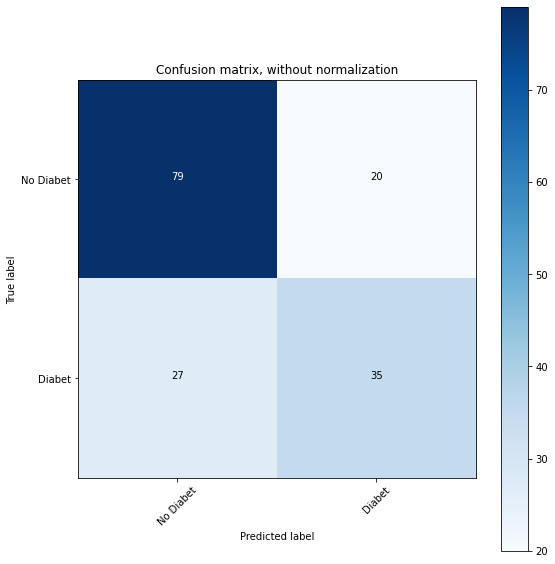

In [55]:
class_names =["No Diabet", "Diabet"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.7979798  0.2020202 ]
 [0.43548387 0.56451613]]


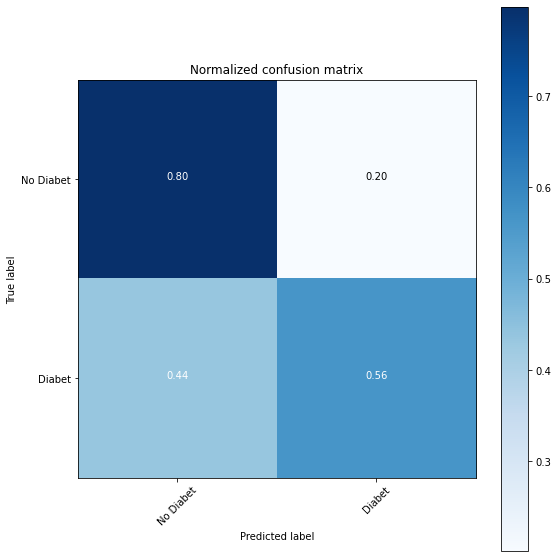

In [56]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()